# Import libraries and modules

In [1]:
# Reload modules before executing user code
%load_ext autoreload
%autoreload 2

import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat
import pandas as pd

# Find current directory
current_dir = os.getcwd()
# Find root directory
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
# Add root directory to path
sys.path.append(root_dir)

print(f"Current directory: {current_dir}")
print(f"Root directory: {root_dir}")

import pysindy.pysindy as ps

from pysindy.feature_library import (
    FourierLibrary, 
    CustomLibrary,
    GeneralizedLibrary,
    PolynomialLibrary,
)

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(1000)  # Seed for reproducibility

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['method'] = 'RK23'
integrator_keywords['rtol'] = 1e-3
integrator_keywords['atol'] = 1e-4

poly_order = 4
threshold = 0
dt = 1

Current directory: /u1/ame805/pysindy_fork/simlab_experiments
Root directory: /u1/ame805/pysindy_fork


# Load data

In [2]:
experiment_dir = 'data'
experiment_file = '01013500_results_train.csv'
exp_dir = os.path.join(experiment_dir, experiment_file)

# read dataframe from csv file
df = pd.read_csv(exp_dir)

time_series = np.linspace(0, len(df)-1, len(df))
s_snow = df['s_snow'].values
s_water = df['s_water'].values
# prcp(mm/day),tmean(c),dayl(s)
temp = df['tmean(c)'].values
precp = df['prcp(mm/day)'].values
dayl = df['dayl(s)'].values

# S_data = np.vstack((s_snow, s_water, temp, precp, dayl)).T
S_data = np.vstack((s_snow, s_water)).T

# Build and fit the model

In [3]:
# functions = [lambda x : np.exp(x), lambda x,y : np.sin(x+y)]
# lib_custom = CustomLibrary(library_functions=functions)
lib_fourier = FourierLibrary()
lib_poly = PolynomialLibrary(degree=poly_order)
lib_generalized = GeneralizedLibrary([lib_fourier, lib_poly])

In [4]:
S_data

array([[   0.        , 1303.00424785],
       [   0.        , 1305.34545661],
       [   0.        , 1310.05663422],
       ...,
       [   0.        , 1502.65074272],
       [   0.        , 1500.55021607],
       [   0.        , 1500.43826063]])

In [5]:
# Fit the model
model = ps.SINDy( 
    optimizer=ps.STLSQ(threshold=threshold),
    # feature_library=ps.PolynomialLibrary(degree=poly_order),
    feature_library=lib_generalized,
)
model.fit(S_data, t=dt)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=<pysindy.feature_library.generalized_library.GeneralizedLibrary object at 0x7f7061ca56a0>,
      feature_names=['x0', 'x1'], optimizer=STLSQ(threshold=0))

In [6]:
# Print the model
model.print()

(x0)' = -0.027 sin(1 x0) + 0.147 cos(1 x0) + -0.019 sin(1 x1) + -0.047 cos(1 x1) + -0.002 1 + 12.894 x0 + 1.520 x1 + 0.039 x0^2 + -0.034 x0 x1 + -0.003 x1^2
(x1)' = 0.017 sin(1 x0) + 0.015 cos(1 x0) + 0.041 sin(1 x1) + 0.024 cos(1 x1) + 0.002 1 + 3.954 x0 + 1.311 x1 + -0.042 x0^2 + -0.003 x1^2


In [7]:
S_data[0]

array([   0.        , 1303.00424785])

In [9]:
integrator_keywords['method'] = 'DOP853'   #'RK45'
integrator_keywords['rtol'] = 1e-9
integrator_keywords['atol'] = 1e-12
n_samples_test = 5000
n_sim, t_sim = model.simulate(S_data[0], t=time_series[:n_samples_test], integrator_kws=integrator_keywords)

# integrator_keywords['method'] = 'Euler'   # 'RK2'   #'RK4' 
# n_sim, t_sim = model.simulate(N_clusters[0], t=t_values[:n_samples_test], 
#                               integrator='fixed_step', integrator_kws=integrator_keywords)

In [10]:
n_sim.shape, t_sim.shape

((197, 2), (197,))

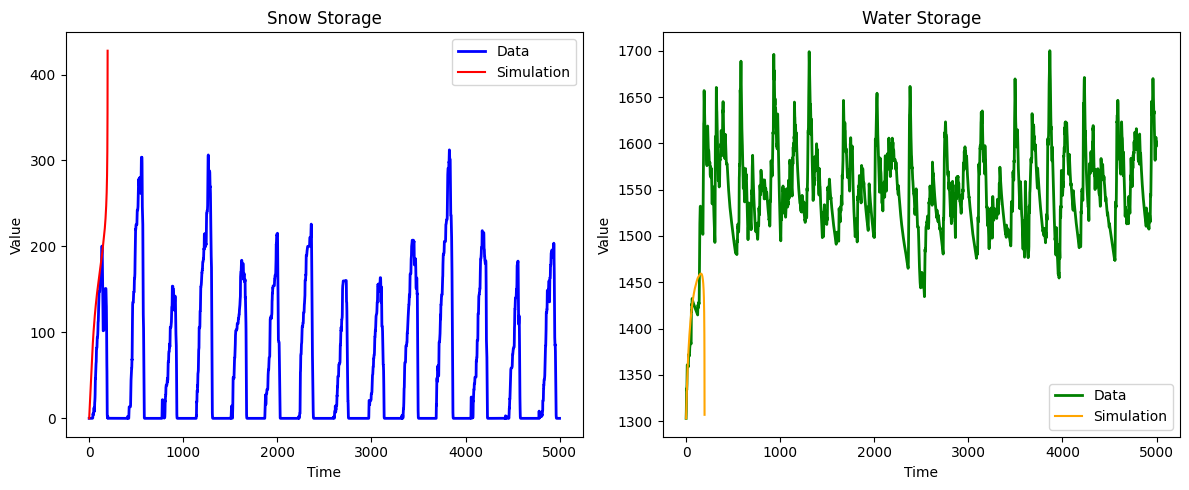

In [11]:
# Create subplot grid with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first data series on the first subplot
axes[0].plot(time_series[:n_samples_test], S_data[:n_samples_test, 0], label='Data', color='b', linestyle='-', linewidth=2)
axes[0].plot(t_sim, n_sim[:, 0], color='r', label='Simulation')
axes[0].set_title('Snow Storage')  # Set subplot title
axes[0].set_xlabel('Time')  # Set xlabel
axes[0].set_ylabel('Value')  # Set ylabel
axes[0].legend()  # Add legend

# Plot the second data series on the second subplot
axes[1].plot(time_series[:n_samples_test], S_data[:n_samples_test, 1], label='Data', color='g', linestyle='-', linewidth=2)
axes[1].plot(t_sim, n_sim[:, 1], color='orange', label='Simulation')
axes[1].set_title('Water Storage')  # Set subplot title
axes[1].set_xlabel('Time')  # Set xlabel
axes[1].set_ylabel('Value')  # Set ylabel
axes[1].legend()  # Add legend

plt.tight_layout()
plt.show()